In [1]:
# load required libraries; this assumes the user has used the requirements.txt to build the venv
import os, zipfile, numpy as np, pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

In [2]:
# automatically detect the user's home directory
HOME = Path.home()

In [3]:
# construct platform-independent paths
BASE = HOME / "Dal" / "CSCI_6055_R" / "gss_green_eds"

In [4]:
# create data paths
DTA_PATH = BASE / "GSS2018.dta"
MODEL_RESULTS_PATH = BASE / "model_results_fulladjustment_updated_20240208.csv"
MORE_MODEL_RESULTS_PATH = BASE / "more_model_results_fulladjustment_updated20240208.csv"

In [5]:
# Load into separate DataFrames
df = pd.read_stata(DTA_PATH, convert_categoricals=False)
df_main = pd.read_csv(MODEL_RESULTS_PATH)
df_more = pd.read_csv(MORE_MODEL_RESULTS_PATH)

### Constructing the Analytic Dataset for the Sophisticated Reproduction

Before generating the descriptive diagnostics required in item 4e of the CSCI 6055 syllabus, it is necessary to reconstruct the analytic dataset that will be used in all subsequent steps. Following Trochim’s guidance that diagnostics and assumption checks must be performed on the exact variables entering the statistical model, only the components of the original R pipeline that are directly relevant to the three research questions are reproduced here.

This involves:
- recoding the five everyday discrimination items and reconstructing the standardized discrimination index (`disc`) exactly as in the original analysis,
- defining the three binary outcome variables corresponding to nature satisfaction, time sufficiency, and weekly exposure,
- applying the same sample restrictions used in the published study (removing cases missing discrimination data and limiting to Ballot 3 respondents),
- retaining only the covariates and survey design variables that enter the fully adjusted Poisson regression models.

The result is a clean analytic dataset `b` containing only the predictor, outcomes, covariates, and survey design elements needed for descriptive diagnostics, model-assumption checks, and the regression models associated with RQ1–RQ3. This selective reconstruction ensures alignment with Trochim’s framework and keeps the analysis focused on the variables that directly inform the statistical tests of 
#### Note:
- I previously listed all the features in GSS2018.dta but for brevity I've deleted that.interest.


In [7]:
# create a subset of df that contains the GSS2018.dta features that we will be using for our reproduction
# these are needed to build all derived variables for RQ1–RQ3
analytic_cols = [
    # Everyday Discrimination Scale (EDS) raw items:
    # These are recoded and then summed/standardized to form disc, disc_c, and disc_4cat
    'disrspct',     # treated with less courtesy or respect
    'poorserv',     # receives poorer service than others
    'notsmart',     # others act as if respondent is not smart
    'afraidof',     # others act as if they are afraid of respondent
    'threaten',     # respondent is threatened or harassed

    # Nature-related outcome items (raw Likert variables):
    # These are transformed into binary outcomes natsat_yn, nattimeok_yn, nattime_yn
    'natsat',       # satisfaction with day-to-day experience of nature
    'nattimeok',    # feels they spend enough time in natural environments
    'nattime',      # frequency of weekly time in natural environments

    # Covariates used in the adjusted models:
    # These become age (numeric), workcat (derived from wrkstat), region_cat (derived from region)
    'age',          # respondent age
    'wrkstat',      # employment status, recoded into workcat
    'region',       # geographic region, recoded into region_cat

    # Survey design variables needed for survey-weighted GLMs:
    'wtssall',      # GSS full-sample survey weight
    'vpsu',         # primary sampling unit (cluster)
    'vstrat',       # stratification variable

    # Sample restriction variable:
    'ballot'        # used to filter respondents to Ballot 3 only
]

In [8]:
# construct the analytic dataset (Python version of R's `b`). Note I use 'b' because Schinasi used it as her final dataset variable
df_b = df[analytic_cols].copy()

In [9]:
# First diagnostic look at the analytic dataset
df_b.describe(include="all")

,disrspct,poorserv,notsmart,afraidof,threaten,natsat,nattimeok,nattime,age,wrkstat,region,wtssall,vpsu,vstrat,ballot
count,1561.000000,1560.000000,1555.000000,1564.000000,1564.000000,1146.000000,1146.000000,1147.00000,2341.000000,2346.000000,2348.000000,2348.000000,2348.000000,2348.000000,2348.000000
mean,3.967329,4.696795,4.445659,5.027494,5.385550,1.607330,2.079407,2.10898,48.971380,2.956522,5.232112,1.000000,1.505111,3347.184412,2.001704
std,1.549883,1.222932,1.499068,1.398706,0.997281,0.779261,0.962971,1.02728,18.060879,2.304678,2.444832,0.611458,0.500080,22.534556,0.818926
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,18.000000,1.000000,1.000000,0.471499,1.000000,3301.000000,1.000000
25%,3.000000,4.000000,4.000000,4.000000,5.000000,1.000000,1.000000,1.00000,34.000000,1.000000,3.000000,0.471499,1.000000,3327.750000,1.000000
50%,4.000000,5.000000,5.000000,6.000000,6.000000,1.000000,2.000000,2.00000,48.000000,2.000000,5.000000,0.942997,2.000000,3354.000000,2.000000
75%,5.000000,6.000000,6.000000,6.000000,6.000000,2.000000,3.000000,3.00000,63.000000,5.000000,7.000000,0.942997,2.000000,3366.000000,3.000000
max,6.000000,6.000000,6.000000,6.000000,6.000000,4.000000,4.000000,4.00000,89.000000,8.000000,9.000000,5.897420,2.000000,3378.000000,3.000000


In [10]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348 entries, 0 to 2347
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   disrspct   1561 non-null   float64
 1   poorserv   1560 non-null   float64
 2   notsmart   1555 non-null   float64
 3   afraidof   1564 non-null   float64
 4   threaten   1564 non-null   float64
 5   natsat     1146 non-null   float64
 6   nattimeok  1146 non-null   float64
 7   nattime    1147 non-null   float64
 8   age        2341 non-null   float64
 9   wrkstat    2346 non-null   float64
 10  region     2348 non-null   int8   
 11  wtssall    2348 non-null   float64
 12  vpsu       2348 non-null   int8   
 13  vstrat     2348 non-null   int16  
 14  ballot     2348 non-null   int8   
dtypes: float64(11), int16(1), int8(3)
memory usage: 213.4 KB


In [11]:
# recode the five discrimination items (1–6 → 6–1) 'so Higher values represent higher frequency'
recode_map = {1: 6, 2: 5, 3: 4, 4: 3, 5: 2, 6: 1}

for col in ['disrspct', 'poorserv', 'notsmart', 'afraidof', 'threaten']:
    df_b[col] = df_b[col].astype('float')
    df_b[col] = df_b[col].replace(recode_map)

In [12]:
# create discrimination indices exactly as in Schinasi’s code
df_b['disc_notscaled'] = (
    df_b['disrspct'] +
    df_b['poorserv'] +
    df_b['notsmart'] +
    df_b['afraidof'] +
    df_b['threaten']
)

In [13]:
# replicate Schinasi’s method by z-scoring each of the five discrimination items and summing them.
# this produces the standardized EDS score used as the main predictor in all regression models.
df_b['disc'] = (
    (df_b['disrspct'] - df_b['disrspct'].mean()) / df_b['disrspct'].std() +
    (df_b['poorserv'] - df_b['poorserv'].mean()) / df_b['poorserv'].std() +
    (df_b['notsmart'] - df_b['notsmart'].mean()) / df_b['notsmart'].std() +
    (df_b['afraidof'] - df_b['afraidof'].mean()) / df_b['afraidof'].std() +
    (df_b['threaten'] - df_b['threaten'].mean()) / df_b['threaten'].std()
)

In [14]:
# flag missing discrimination values (needed before filtering)
df_b['disc_miss'] = df_b['disc'].isna().astype(int)

In [15]:
# drop rows with missing EDS (match Schinasi’s analytic sample)
df_b = df_b[df_b['disc_miss'] == 0].copy()

In [16]:
# restrict to Ballot 3 respondents (only these answered the nature questions)
df_b = df_b[df_b['ballot'] == 3].copy()

In [17]:
# create binary nature outcomes (0 = enough / satisfied, 1 = not enough / dissatisfied)

# natsat: 1–2 = satisfied (0), 3–4 = dissatisfied (1)
df_b['natsat_yn'] = df_b['natsat'].apply(lambda x: 0 if x in [1,2] else (1 if x in [3,4] else np.nan))

# nattimeok: 1–2 = enough time (0), 3–4 = not enough (1)
df_b['nattimeok_yn'] = df_b['nattimeok'].apply(lambda x: 0 if x in [1,2] else (1 if x in [3,4] else np.nan))

# nattime: 1–2 = at least weekly (0), 3–4 = less than weekly (1)
df_b['nattime_yn'] = df_b['nattime'].apply(lambda x: 0 if x in [1,2] else (1 if x in [3,4] else np.nan))

In [19]:
# sanity check - let's check to see if we get the same median (-0.46543) as Shinasi
df_b['disc'].median()

-0.46543070315874246

In [20]:
# median confirmed as the same - center the standardized discrimination score at the Ballot-3 median for interpretability in regression models
disc_median = df_b['disc'].median()
df_b['disc_c'] = df_b['disc'] - disc_median

In [21]:
# recode work status into the categories used in the regression models
df_b['workcat'] = df_b['wrkstat'].apply(
    lambda x: 'working for pay' if x in [1,2]
    else ('Unemployed or retired' if x in [3,4,5]
    else ('In school' if x == 6
    else ('Keeping house' if x == 7 else 'Other')))
)

In [23]:
# recode region into nine US Census regions for use as a model covariate
region_map = {
    1: 'New England',
    2: 'Middle Atlantic',
    3: 'Eastern North Central',
    4: 'Western North Central',
    5: 'South Atlantic',
    6: 'Eastern South Central',
    7: 'Western South Central',
    8: 'Mountain',
    9: 'Pacific'
}

In [24]:
df_b['region_cat'] = df_b['region'].map(region_map)

### Univariate Distributions

We now perform step 4e: univariate, bivariate, and data-quality diagnostics on the cleaned analytic dataset.


In [26]:
# summary statistics for key continuous variables
df_b[['disc', 'disc_c', 'age']].describe()

,disc,disc_c,age
count,768.000000,768.000000,768.000000
mean,0.083939,0.549369,46.518229
std,3.648976,3.648976,17.943405
min,-4.725426,-4.259995,18.000000
25%,-2.617299,-2.151869,32.000000
50%,-0.465431,0.000000,44.000000
75%,2.000212,2.465643,60.000000
max,12.368085,12.833516,89.000000


In [27]:
# frequency tables for the three nature outcomes
df_b['natsat_yn'].value_counts(dropna=False)
df_b['nattimeok_yn'].value_counts(dropna=False)
df_b['nattime_yn'].value_counts(dropna=False)

nattime_yn
0.0    500
1.0    251
NaN     17
Name: count, dtype: int64

<Axes: >

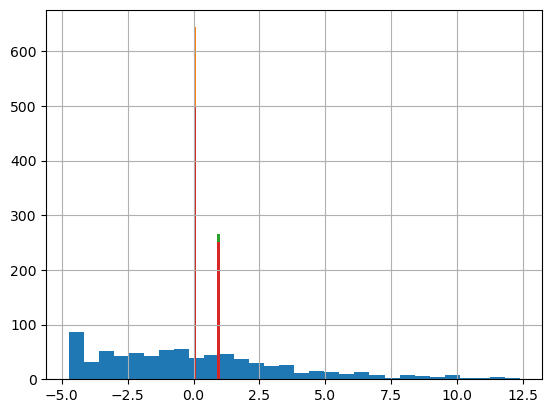

In [28]:
# histogram of standardized discrimination
df_b['disc'].hist(bins=30)

# histograms for the nature outcomes
df_b['natsat_yn'].hist()
df_b['nattimeok_yn'].hist()
df_b['nattime_yn'].hist()

<Axes: xlabel='disc', ylabel='natsat'>

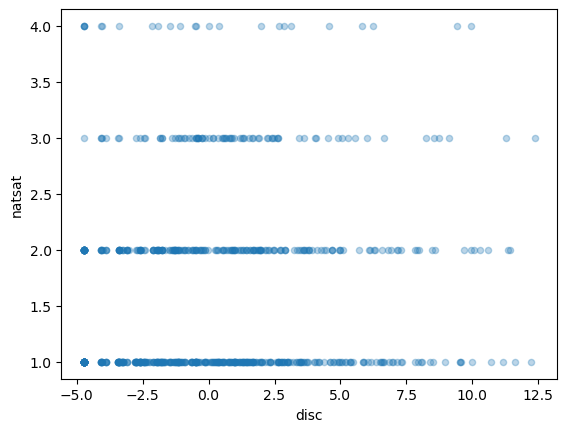

In [29]:
# scatter relationship between discrimination and nature satisfaction (raw Likert)
df_b.plot.scatter(x='disc', y='natsat', alpha=0.3)

<Axes: title={'center': 'disc'}, xlabel='nattime_yn'>

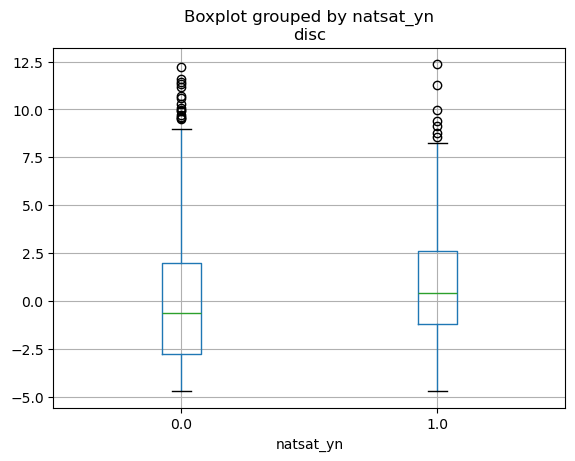

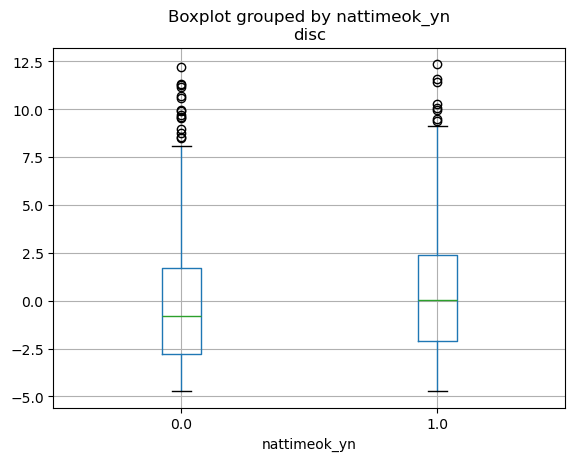

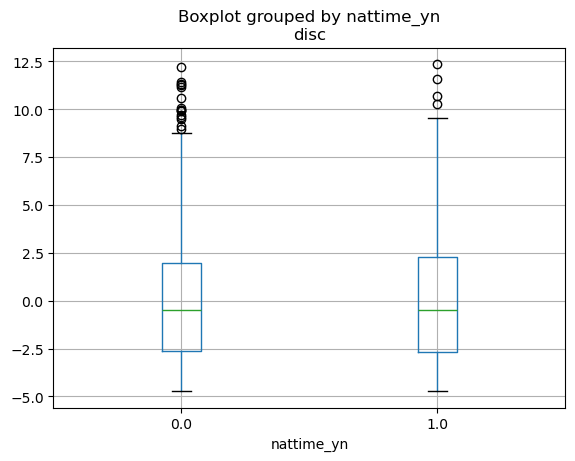

In [30]:
# discrimination distribution by binary outcomes
df_b.boxplot(column='disc', by='natsat_yn')
df_b.boxplot(column='disc', by='nattimeok_yn')
df_b.boxplot(column='disc', by='nattime_yn')

In [31]:
# missingness check across key variables
df_b[['disc','natsat_yn','nattimeok_yn','nattime_yn','age','workcat','region_cat']].isna().sum()

disc             0
natsat_yn       17
nattimeok_yn    17
nattime_yn      17
age              0
workcat          0
region_cat       0
dtype: int64

In [32]:
df_b[['disrspct','poorserv','notsmart','afraidof','threaten']].agg(['min','max'])

,disrspct,poorserv,notsmart,afraidof,threaten
min,1.0,1.0,1.0,1.0,1.0
max,6.0,6.0,6.0,6.0,6.0


In [33]:
# simple univariate outlier scan for disc and age
df_b[['disc','age']].describe()

,disc,age
count,768.000000,768.000000
mean,0.083939,46.518229
std,3.648976,17.943405
min,-4.725426,18.000000
25%,-2.617299,32.000000
50%,-0.465431,44.000000
75%,2.000212,60.000000
max,12.368085,89.000000


In [10]:
df_main

,Unnamed: 0,naturevar,subgroup,beta,se,deviance,RR,LL,UL
0,m1,nattimeok,main,0.021647,0.011462,528.747540,1.02,1.00,1.05
1,m2,nattimeok,men,0.008047,0.018703,520.442683,1.01,0.97,1.05
2,m3,nattimeok,women,0.034424,0.016361,520.442683,1.04,1.00,1.07
3,m3a,nattimeok,missing gender,-0.027717,0.049697,520.442683,0.97,0.88,1.07
4,m1lrt,nattimeok,gender adj for LRT,0.021656,0.011412,521.352008,1.02,1.00,1.05
5,m4,nattimeok,white,0.028861,0.014305,514.539080,1.03,1.00,1.06
6,m5,nattimeok,nonwhite,0.015655,0.028494,514.539080,1.02,0.96,1.07
7,m2lrt,nattimeok,race adj for LRT,0.025295,0.011597,514.659300,1.03,1.00,1.05
8,m6,natsat,main,0.063397,0.021444,383.712329,1.07,1.02,1.11
9,m7,natsat,men,0.021943,0.037783,375.783753,1.02,0.95,1.10


In [11]:
df_more

,Unnamed: 0,naturevar,subgroup,beta,se,deviance,RR,LL,UL
0,m11,nat_timeoncewk,main,0.002381,0.018529,529.285358,1.00,0.97,1.04
1,m12,nat_timeoncewk,men,0.010117,0.023432,523.807637,1.01,0.96,1.06
2,m13,nat_timeoncewk,women,0.014008,0.025320,523.807637,1.01,0.97,1.07
3,m13a,nat_timeoncewk,missinggender,-0.092928,0.066735,523.807637,0.91,0.80,1.04
4,m5lrt,nat_timeoncewk,gender adj for lrt,0.003407,0.018569,526.290841,1.00,0.97,1.04
5,m14,nat_timeoncewk,white,-0.012505,0.024610,519.248840,0.99,0.94,1.04
6,m15,nat_timeoncewk,nonwhite,0.038073,0.025222,519.248840,1.04,0.99,1.09
7,m6lrt,nat_timeoncewk,race adj for lrt,0.004426,0.018536,520.977644,1.00,0.97,1.04


In [14]:
df['EDS_raw'] = df[['disrspct', 'poorserv', 'notsmart', 'afraidof', 'threaten']].sum(axis=1)
df['EDS_z'] = (df['EDS_raw'] - df['EDS_raw'].mean()) / df['EDS_raw'].std()

C:\Users\MCEUser\AppData\Local\Temp\ipykernel_8608\3920447763.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EDS_raw'] = df[['disrspct', 'poorserv', 'notsmart', 'afraidof', 'threaten']].sum(axis=1)
C:\Users\MCEUser\AppData\Local\Temp\ipykernel_8608\3920447763.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EDS_z'] = (df['EDS_raw'] - df['EDS_raw'].mean()) / df['EDS_raw'].std()
